In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurments = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Geting the column names for the tables
print("-Measurement Table-")
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c["name"], c["type"])

print("\n")

print("-Station Table-")
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c["name"], c["type"])

-Measurement Table-
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


-Station Table-
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurments.date).group_by('date').\
    order_by(Measurments.date.desc()).first()[0]
print(recent_date)

2017-08-23


<Axes: >

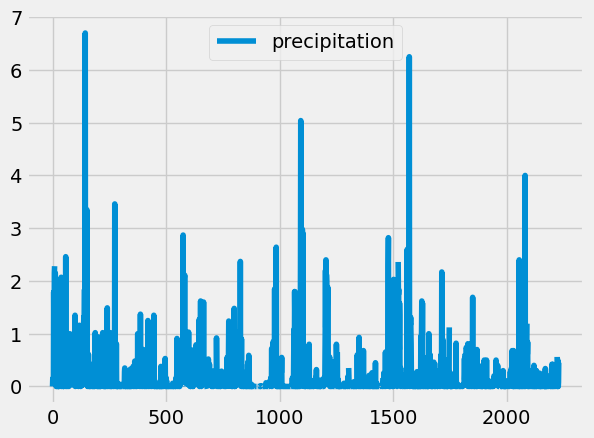

In [109]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = recent_date.split('-')
query_date =  dt.date(int(year_ago[0]), int(year_ago[1]), int(year_ago[2])) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the data and precipitation scores
new = session.query(Measurments.prcp, Measurments.date).\
    filter(Measurments.date >= query_date).order_by(Measurments.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
new_df = pd.DataFrame(new, columns=["precipitation", "dates"])

# Sort the dataframe by date
new_df.sort_values(by=['dates'])

# Use Pandas Plotting with Matplotlib to plot the data
new_df.plot()

In [105]:

new = session.query(Measurments.prcp, Measurments.date).\
    filter(Measurments.date >= query_date).order_by(Measurments.date).all()

# prcp = [i[0] for i in new]
# dates = [i[1] for i in new]
# data_frame = pd.DataFrame(
#     {"dates":dates,
#      "percip":prcp
#     }
# )
# data_frame.describe()

new_df = pd.DataFrame(new, columns=["precipitation", "dates"])
new_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [106]:
new_df.sort_values(by=['dates'])

,prcp,dates
0,0.00,2016-08-23
1,0.15,2016-08-23
2,0.05,2016-08-23
3,NaN,2016-08-23
4,0.02,2016-08-23
...,...,...
2225,0.50,2017-08-22
2228,0.08,2017-08-23
2226,0.00,2017-08-23
2227,0.00,2017-08-23


In [93]:
new = session.query(Measurments.prcp, Measurments.date).\
    filter(Measurments.date == query_date).all()
new

[(0.0, '2016-08-23'),
 (0.15, '2016-08-23'),
 (0.05, '2016-08-23'),
 (None, '2016-08-23'),
 (0.02, '2016-08-23'),
 (1.79, '2016-08-23'),
 (0.7, '2016-08-23')]

In [110]:
# Use Pandas to calculate the summary statistics for the precipitation data
new_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()